In [1]:
from collections import Counter
import datetime
import os
import re
import time
from urllib import request as urllib_request

from bs4 import BeautifulSoup
# import lcp.reuse as reuse
# from Bio import Entrez
# from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from pybliometrics.scopus import AbstractRetrieval
# This will need an API key from: https://dev.elsevier.com/apikey/manage
import pybliometrics.scopus as pbs

# 1. PubMed

Search PubMed for papers

https://www.ncbi.nlm.nih.gov/pubmed/

https://www.ncbi.nlm.nih.gov/books/NBK25499/

In [8]:
dir(pbs)

['AbstractRetrieval',
 'AffiliationRetrieval',
 'AffiliationSearch',
 'AuthorRetrieval',
 'AuthorSearch',
 'BASE_PATH',
 'CONFIG_FILE',
 'CitationOverview',
 'DEFAULT_PATHS',
 'Dict',
 'HTTPAdapter',
 'KEYS',
 'List',
 'NamedTuple',
 'Optional',
 'OrderedDict',
 'Path',
 'PlumXMetrics',
 'RATELIMITS',
 'RETRIEVAL_BASE',
 'Retrieval',
 'Retry',
 'SEARCH_BASE',
 'SEARCH_MAX_ENTRIES',
 'ScopusSearch',
 'Search',
 'SerialSearch',
 'SerialTitle',
 'Session',
 'SubjectClassifications',
 'Tuple',
 'URLS',
 'Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'abstract_citation',
 'abstract_retrieval',
 'adapter',
 'affiliation_retrieval',
 'affiliation_search',
 'author_retrieval',
 'author_search',
 'chained_get',
 'check_field_consistency',
 'check_integrity',
 'check_parameter_value',
 'checks',
 'config',
 'configparser',
 'constants',
 'create_config',
 'datetime',
 'deduplicate',
 'defaultdict',
 'deque'

# Define folders

In [2]:
SEARCH_RESULT_FOLDER = 'search_results'
PUBMED_CITATION_FOLDER = 'Pubmed_Citations'

# Define search queries

# options to search Google Scholar

Packages found online:
- https://github.com/ckreibich/scholar.py
- https://github.com/venthur/gscholar
- https://github.com/adeel/google-scholar-scraper
- http://code.activestate.com/recipes/523047-search-google-scholar/
- https://github.com/erdiaker/torrequest
- https://github.com/NikolaiT/GoogleScraper
- https://stackoverflow.com/questions/8049520/web-scraping-javascript-page-with-python
- https://scholar.google.com/scholar/help.html
- https://superuser.com/questions/565722/how-to-config-tor-to-use-a-http-socks-proxy

## Requirements

1. Browse with JS enabled. requests library uses http. Otherwise google will think (correctly) that you are a robot.
2. Change IP every time, or google will block.

In [ ]:
from scholarly import scholarly

In [ ]:
PROJECT = 'eICU'

# Search by Google Scholar publication ID
search_results = []
if PROJECT == 'eICU':
    try:
        search_results.append(scholarly.search_citedby(11878669525996073977))
    except Exception as e:
        print(e)

total_results = search_results[0].total_results

In [ ]:
# all_pubs = list(search_results)
all_pubs = []
for i in range(total_results):
    print(100*i/total_results)
    try:
        ct = next(search_results)
        all_pubs.append({
            'title': ct['bib']['title'],
            'pub_year': ct['bib']['pub_year']
        })
    except:
        pass
# print(all_pubs)

# Manually get the number of citations from Google Scholar
## Methods:
### 1. Go to: https://scholar.google.com/
### 2. Type a query to get a specific MIMIC DB, i.e., "`mimic-iv`" for MIMIC-IV
### 3. Find the original paper (usually the first result, or top cited one)
### 4. Click on "`Cited by ###`" underneath the brief abstract
### 5. On the left side, click "`Custom range...`"
### 6. In both boxes, type the year you want to query, i.e., "`2023 - 2023`" to return results for only 2023, click "`Search`"
### 7. At the top, under the search bar is the number of citations that year (note, the "`About ### results`" is the exact number of results until around 1000 or so when it rounds to the nearest 20 I think due to the massive pagination request but still close enough at those numbers)

----
### TODO: automate this!!! but I know GS will get mad at me for all those requests ...

In [5]:
google_scholar_mimic_pubs = {
    'mimic-i': {
        '1997' :   2,
        '1998' :   1,
        '1999' :   2,
        '2000' :   4,
        '2001' :   4,
        '2002' :   4,
        '2003' :   3,
        '2004' :   7,
        '2005' :   5,
        '2006' :  10,
        '2007' :  12,
        '2008' :   3,
        '2009' :   9,
        '2010' :  10,
        '2011' :  12,
        '2012' :   7,
        '2013' :   9,
        '2014' :   7,
        '2015' :  13,
        '2016' :  18,
        '2017' :  25,
        '2018' :  14,
        '2019' :  17,
        '2020' :  30,
        '2021' :  29,
        '2022' :  23,
        '2023' :  19,
        '2024' :   0
    },
    'mimic-ii': {
        '1997' :    0,
        '1998' :    0,
        '1999' :    0,
        '2000' :    0,
        '2001' :    0,
        '2002' :    0,
        '2003' :    0,
        '2004' :    0,
        '2005' :    0,
        '2006' :    0,
        '2007' :    0,
        '2008' :    0,
        '2009' :    0,
        '2010' :    0,
        '2011' :   11,
        '2012' :   37,
        '2013' :   53,
        '2014' :   81,
        '2015' :  126,
        '2016' :  175,
        '2017' :  116,
        '2018' :  122,
        '2019' :  115,
        '2020' :  118,
        '2021' :  101,
        '2022' :  112,
        '2023' :   91,
        '2024' :    0
    },
    'mimic-iii': {
        '1997' :    0,
        '1998' :    0,
        '1999' :    0,
        '2000' :    0,
        '2001' :    0,
        '2002' :    0,
        '2003' :    0,
        '2004' :    0,
        '2005' :    0,
        '2006' :    0,
        '2007' :    0,
        '2008' :    0,
        '2009' :    0,
        '2010' :    0,
        '2011' :    0,
        '2012' :    0,
        '2013' :    0,
        '2014' :    1,
        '2014' :    0,
        '2015' :    0,
        '2016' :   24,
        '2017' :  147,
        '2018' :  428,
        '2019' :  650,
        '2020' :  960,
        '2021' : 1260,
        '2022' : 1440,
        '2023' : 1460,
        '2024' :  112
    },
    'mimic-iv': {
        '1997' :   0,
        '1998' :   0,
        '1999' :   0,
        '2000' :   0,
        '2001' :   0,
        '2002' :   0,
        '2003' :   0,
        '2004' :   0,
        '2005' :   0,
        '2006' :   0,
        '2007' :   0,
        '2008' :   0,
        '2009' :   0,
        '2010' :   0,
        '2011' :   0,
        '2012' :   0,
        '2013' :   0,
        '2014' :   0,
        '2014' :   0,
        '2015' :   0,
        '2016' :   0,
        '2017' :   0,
        '2018' :   0,
        '2019' :   0,
        '2020' :   5,
        '2021' :  57,
        '2022' : 215,
        '2023' : 314,
        '2024' :  17
    },
    'mimic-cxr': {
        '1997' :   0,
        '1998' :   0,
        '1999' :   0,
        '2000' :   0,
        '2001' :   0,
        '2002' :   0,
        '2003' :   0,
        '2004' :   0,
        '2005' :   0,
        '2006' :   0,
        '2007' :   0,
        '2008' :   0,
        '2009' :   0,
        '2010' :   0,
        '2011' :   0,
        '2012' :   0,
        '2013' :   0,
        '2014' :   0,
        '2014' :   0,
        '2015' :   0,
        '2016' :   0,
        '2017' :   0,
        '2018' :   0,
        '2019' :   0,
        '2020' :  24,
        '2021' :  92,
        '2022' : 181,
        '2023' : 338,
        '2024' :  22
    }
}

closed_datasets = {
    # Sudlow, Cathie, et al. "UK biobank: an open access resource for identifying the causes of a wide range of complex diseases of middle and old age." PLoS medicine 12.3 (2015): e1001779.
    'UK Biobank': {
        '2015':   18,
        '2016':   95,
        '2017':  232,
        '2018':  468,
        '2019':  697,
        '2020':  891,
        '2021': 1260,
        '2022': 1650,
        '2023': 2010,
        '2024':  183
    },
    # 'CheXpert': {
    #     '2017':   1,
    #     '2018':   3,
    #     '2019':  64,
    #     '2020': 239,
    #     '2021': 449,
    #     '2022': 599,
    #     '2023': 573,
    #     '2024':  12
    # },
    # Williamson, Elizabeth J., et al. "OpenSAFELY: factors associated with COVID-19 death in 17 million patients." Nature 584.7821 (2020): 430.
    # https://doi.org/10.1038/s41586-020-2521-4
    'OpenSAFELY': {
        '2019':   1,
        '2020': 194,
        '2021': 257,
        '2022': 124,
        '2023':  70,
        '2024':   6
    },
    # All of Us Research Program Investigators. "The “All of Us” research program." New England Journal of Medicine 381.7 (2019): 668-676.
    # https://doi.org/10.1056/NEJMsr1809937
    'All of Us': {
        '2018':   1,
        '2019':  13,
        '2020':  92,
        '2021': 175,
        '2022': 226,
        '2023': 332,
        '2024':  23
    },
    # (scopus)
    # 'All of Us': {
    #     '2018':   1,
    #     '2019':   7,
    #     '2020':  80,
    #     '2021': 128,
    #     '2022': 296,
    #     '2023': 261,
    #     '2024':  48
    # }
}

other_datasets = {
    # https://doi.org/10.1038/sdata.2018.178
    'eICU-CRD': {
        '2018':   4,
        '2019':  45,
        '2020': 136,
        '2021': 194,
        '2022': 263,
        '2023': 323,
        '2024':  51
    },
    # (scopus)
    # 'eICU-CRD': {
    #     '2019':  23,
    #     '2020':  77,
    #     '2021': 130,
    #     '2022': 168,
    #     '2023': 215,
    #     '2024':  27
    # },
    # https://doi.org/10.13026/nkwc-js72 (PN)
    # 'HiRID': {
    #     '2021':  3,
    #     '2022':  6,
    #     '2023': 15,
    #     '2024':  2
    # },
    # https://doi.org/10.1038/s41591-020-0789-4 (SR)
    # 'HiRID': {
    #     '2021':  3,
    #     '2022':  6,
    #     '2023': 15,
    #     '2024':  2
    # },
    # https://doi.org/10.1097/CCM.0000000000004916
    # (scopus)
    # 'AmsterdamUMCdb': {
    #     '2021':  7,
    #     '2022': 22,
    #     '2023': 40,
    #     '2024':  4
    # }
    # ----
    'Dutch Data Warehouse': {
        '2021':  2,
        '2022': 14,
        '2023': 12,
        '2024':  1
    }
}

total_funding = {
    'MIMIC': 8253202,
    'UK Biobank': 522.1e6,
    # Welcome Trust (222097), MRC (MR/W016729/1), MRC (MR/V015757/1)?, MC_PC_20051, MC_PC_20058,
    # MC_PC_20059, NIHR135559, COV-LT-0009, COV-LT2-0073
    'OpenSAFELY': 2874941.71 + 774508.54 + 0 + 6055626.76 + 19188252.00 + 11454881.49 + 403228.32 + 12109587.17 + 854028.70,
    'All of Us': 1.5e9,
    'eICU-CRD': 0,
    'HiRID': 0,
}

# Try Scopus

In [2]:
import pybliometrics

dir(pybliometrics)

ModuleNotFoundError: No module named 'importlib_metadata'

# Graph the results

c:\Users\lbmccullum\OneDrive - Inside MD Anderson\Documents\citation-tracker\env\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


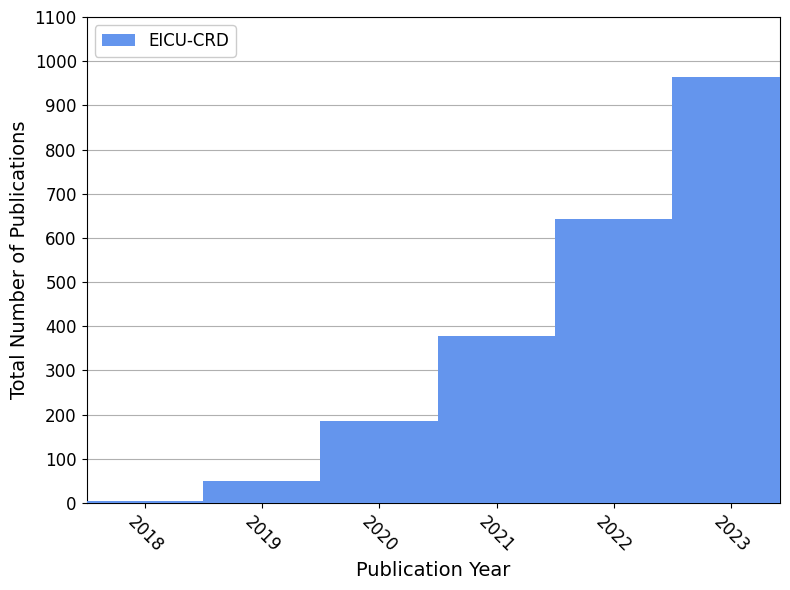

In [9]:
min_year = 2018 #2005
ytick_interval = 100 #1000
current_db = other_datasets.copy() #google_scholar_mimic_pubs.copy()

years = [int(y) for y in current_db[list(current_db.keys())[0]].keys()]
db_order = ['eICU-CRD'] #['mimic-i','mimic-ii','mimic-iii','mimic-iv','mimic-cxr']
colors = [
    'cornflowerblue',
    'lightsteelblue',
    'dimgray',
    'lightcoral',
    'firebrick'
][:len(db_order)]

plt.figure(figsize=(8,6))
graph_data = []
for db in current_db.keys():
    graph_data.append(np.concatenate(np.array([np.array(v*[int(y)]) for y,v in current_db[db].items()]).flatten()))
max_citations = np.concatenate(graph_data).shape[0]

plt.hist(graph_data, len(graph_data[0]), color=colors, label=[s.upper() for s in db_order], cumulative=1, stacked=True, density=False, zorder=3)
plt.xlim([min_year, max(years)-0.08])
plt.xticks(rotation=-45)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xticks(np.arange(min_year, max(years), 1) + 0.5)
ax.set_xticklabels(np.arange(min_year, max(years), 1), fontsize=12)
ax.set_yticks(np.arange(0, max_citations+ytick_interval, ytick_interval))
ax.set_yticklabels(np.arange(0, max_citations+ytick_interval, ytick_interval), fontsize=12)
plt.xlabel('Publication Year', fontsize=14)
plt.ylabel('Total Number of Publications', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(len(db_order)-1, -1, -1)
legend = plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left', fontsize=12)
legend.get_frame().set_alpha(1)
plt.grid(zorder=-1, axis='y')
plt.tight_layout()
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'cumulative_histogram.png'))
plt.show()

# Plot the growth of each DB adjusted from the start time

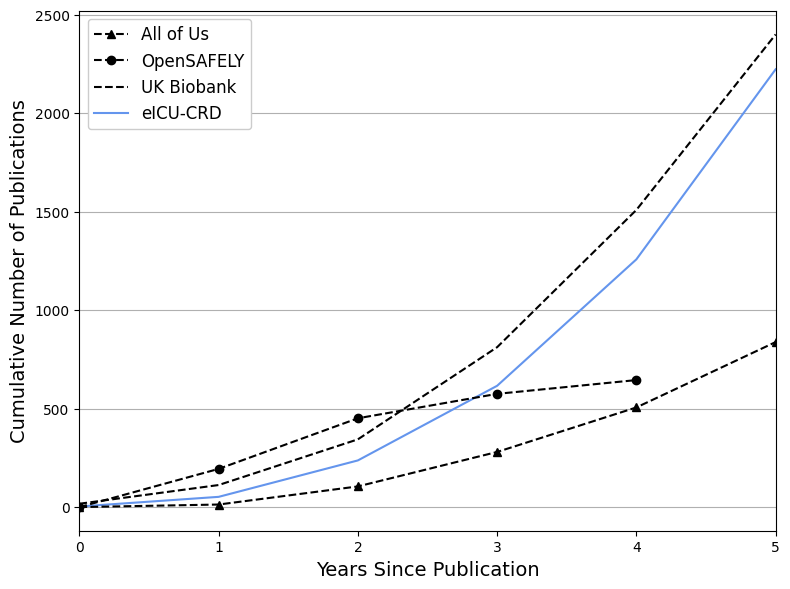

In [17]:
max_year = 2023
ALL_MIMIC = True
current_db = other_datasets.copy() #google_scholar_mimic_pubs.copy()
fig_title = 'eICU-CRD' #'All MIMIC'
xlim_max = 5 #8

years = [int(y) for y in current_db[list(current_db.keys())[0]].keys()]
db_order = ['eICU-CRD'] #['mimic-i','mimic-ii','mimic-iii','mimic-iv','mimic-cxr']
colors = [
    'cornflowerblue',
    'lightsteelblue',
    'dimgray',
    'lightcoral',
    'firebrick'
][:len(db_order)]

plt.figure(figsize=(8,6))

if ALL_MIMIC:
    all_x_data = []
    all_y_data = []
for i,db in enumerate(db_order):
    for y,v in current_db[db].items():
        if v != 0:
            start_year = int(y)
            break
    y_data = [v for y,v in current_db[db].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
    y_data = np.cumsum(y_data)
    if ALL_MIMIC:
        all_y_data.append(y_data)
    else:
        x_data = range(len(y_data))
        plt.plot(x_data, y_data, color=colors[i], label=db.upper())
if ALL_MIMIC:
    max_len = max([len(a) for a in all_y_data])
    all_x_data = range(max_len)
    all_y_data = np.cumsum(np.sum([np.pad(a, (0, max_len-len(a)), 'constant') for a in all_y_data], axis=0))
    plt.plot(all_x_data[:7], all_y_data[:7], color=colors[i], label=fig_title)

closed_markers = [None, 'o', '^', 's']
for i,closed_dataset in enumerate(closed_datasets.items()):
    # if closed_dataset[0] == 'UK Biobank':
    #     # UK Biobank for comparison
    #     start_year = int(list(closed_dataset[1].keys())[0])
    #     y_data = [v for y,v in closed_dataset[1].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
    #     y_data = np.cumsum(y_data)
    #     x_data = range(len(y_data))
    #     plt.plot(x_data[:7], y_data[:7], color='k', linestyle='--', marker=closed_markers[i], label=closed_dataset[0])
    start_year = int(list(closed_dataset[1].keys())[0])
    y_data = [v for y,v in closed_dataset[1].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
    y_data = np.cumsum(y_data)
    x_data = range(len(y_data))
    plt.plot(x_data[:xlim_max+1], y_data[:xlim_max+1], color='k', linestyle='--', marker=closed_markers[i], label=closed_dataset[0])

plt.xlabel('Years Since Publication', fontsize=14)
plt.ylabel('Cumulative Number of Publications', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(len(labels)-1, -1, -1)
legend = plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left', fontsize=12)
legend.get_frame().set_alpha(1)
plt.grid(zorder=-1, axis='y')
plt.xlim([0,xlim_max])
plt.tight_layout()
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'MIMIC-together_all-time_all-closed.png'))
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'MIMIC-together_all-time_UKBiobank.png'))
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'MIMIC-together_all-time.png'))
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'MIMIC-separate_all-time.png'))
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'cumulative_line-plot_baseline.png'))
plt.show()

# Plot the growth of each DB adjusted from the start time and normalized by total funding received

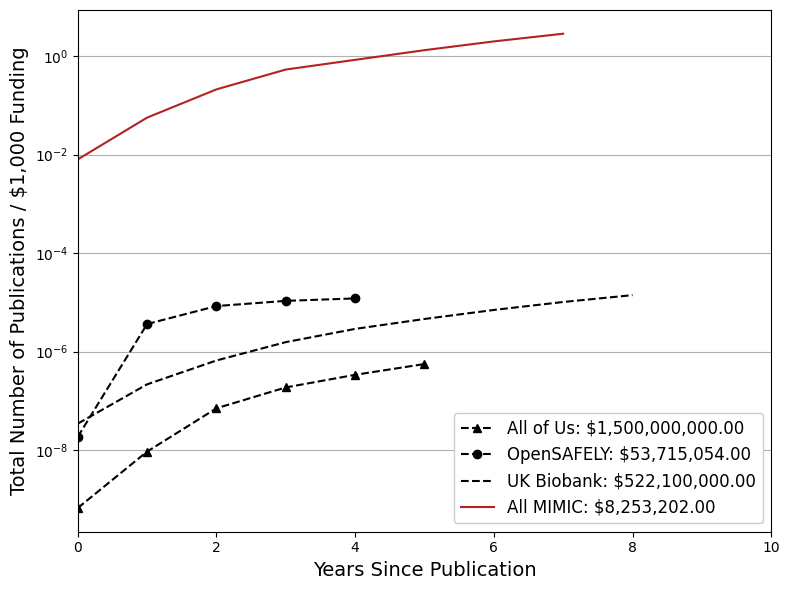

In [41]:
colors = [
    'cornflowerblue',
    'lightsteelblue',
    'dimgray',
    'lightcoral',
    'firebrick'
]
max_year = 2023
ALL_MIMIC = True

years = [int(y) for y in google_scholar_mimic_pubs[list(google_scholar_mimic_pubs.keys())[0]].keys()]
db_order = ['mimic-i','mimic-ii','mimic-iii','mimic-iv','mimic-cxr']

plt.figure(figsize=(8,6))

if ALL_MIMIC:
    all_x_data = []
    all_y_data = []
for i,db in enumerate(db_order):
    for y,v in google_scholar_mimic_pubs[db].items():
        if v != 0:
            start_year = int(y)
            break
    y_data = [v for y,v in google_scholar_mimic_pubs[db].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
    y_data = np.cumsum(y_data)
    if ALL_MIMIC:
        all_y_data.append(y_data)
    else:
        x_data = range(len(y_data))
        plt.plot(x_data, y_data, color=colors[i], label=db.upper())
if ALL_MIMIC:
    max_len = max([len(a) for a in all_y_data])
    all_x_data = range(max_len)
    all_y_data = np.cumsum(np.sum([np.pad(a, (0, max_len-len(a)), 'constant') for a in all_y_data], axis=0))
    all_y_data = all_y_data/total_funding['MIMIC']
    total_funds = int(total_funding['MIMIC'])
    plt.plot(all_x_data[:8], 1000*all_y_data[:8], color=colors[i], label=f'All MIMIC: ${total_funds:,.2f}')

closed_markers = [None, 'o', '^', 's']
for i,closed_dataset in enumerate(closed_datasets.items()):
    # if closed_dataset[0] == 'UK Biobank':
    #     # UK Biobank for comparison
    #     start_year = int(list(closed_dataset[1].keys())[0])
    #     y_data = [v for y,v in closed_dataset[1].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
    #     y_data = np.cumsum(y_data)
    #     x_data = range(len(y_data))
    #     try:
    #         total_funds = int(total_funding[closed_dataset[0]])
    #         plt.plot(x_data, y_data/total_funding[closed_dataset[0]], color='k', linestyle='--', marker=closed_markers[i], label=f'{closed_dataset[0]}: ${total_funds:,.2f}')
    #     except KeyError:
    #         continue
    start_year = int(list(closed_dataset[1].keys())[0])
    y_data = [v for y,v in closed_dataset[1].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
    y_data = np.cumsum(y_data)
    x_data = range(len(y_data))
    try:
        total_funds = int(total_funding[closed_dataset[0]])
        plt.plot(x_data, y_data/total_funding[closed_dataset[0]], color='k', linestyle='--', marker=closed_markers[i], label=f'{closed_dataset[0]}: ${total_funds:,.2f}')
    except KeyError:
        continue


plt.xlabel('Years Since Publication', fontsize=14)
plt.ylabel('Total Number of Publications / $1,000 Funding', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(len(labels)-1, -1, -1)
legend = plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=12)
legend.get_frame().set_alpha(1)
plt.grid(zorder=-1, axis='y')
plt.xlim([0,10])
plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'funding_MIMIC-together_all-time_all-closed_log.png'))
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'funding_MIMIC-together_all-time_all-closed.png'))   # DONE
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'funding_MIMIC-together_all-time_UKBiobank.png'))    # DONE
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'funding_MIMIC-together_all-time.png'))              # DONE
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'funding_MIMIC-separate_all-time.png'))
# plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, 'google_scholar', 'funding_cumulative_line-plot_baseline.png'))
plt.show()

# Compile all citations of MIMIC from Pubmed

IndexError: list index out of range

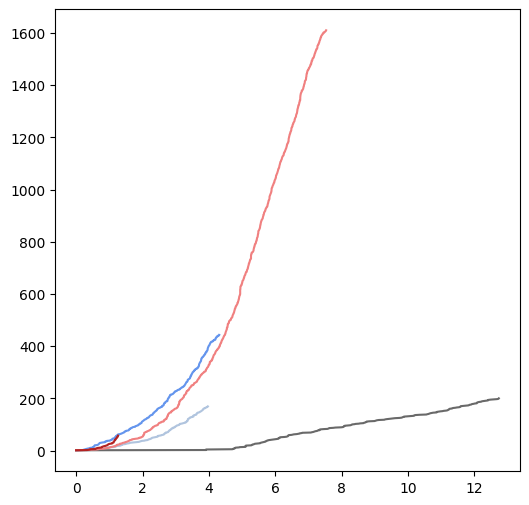

In [48]:
colors = [
    'cornflowerblue',
    'lightsteelblue',
    'dimgray',
    'lightcoral',
    'firebrick'
]
all_dbs = [f for f in os.listdir(PUBMED_CITATION_FOLDER) if f.endswith('.csv')]
combine_mimic = False

plt.figure(figsize=(6,6))
MIMIC_citations = {}
if combine_mimic:
    combined_pub_dates = []
    combined_plot_pub_dates = []
    color_i = 0
for i,db in enumerate(all_dbs):
    db_name = db.split('.')[0]
    temp_df = pd.read_csv(os.path.join(PUBMED_CITATION_FOLDER, db))
    pub_dates = sorted([datetime.datetime.strptime(d,'%Y/%m/%d') for d in temp_df['Create Date'].tolist()])
    # if db_name == 'MIMIC-II':
    #     pub_dates = pub_dates[1:]
    plot_pub_dates = [(d-pub_dates[0]).days/365 for d in pub_dates]
    if combine_mimic:
        if 'MIMIC' in db_name:
            combined_pub_dates.extend(pub_dates)
            combined_plot_pub_dates.extend(plot_pub_dates)
        else:
            plt.plot(plot_pub_dates, range(1,len(plot_pub_dates)+1), color=colors[color_i], label=f'{db_name}')
            MIMIC_citations[db_name] = pub_dates
            color_i += 1
    else:
        plt.plot(plot_pub_dates, range(1,len(plot_pub_dates)+1), color=colors[i], label=f'{db_name}')
        MIMIC_citations[db_name] = pub_dates
if combine_mimic:
    combined_plot_pub_dates = sorted(combined_plot_pub_dates)
    plt.plot(combined_plot_pub_dates, range(1,len(combined_plot_pub_dates)+1), color=colors[color_i], label='Combined MIMIC')
    MIMIC_citations['combined_MIMIC'] = combined_pub_dates
plt.xlabel('Years Since Publication', fontsize=14)
plt.ylabel('Cummulative Citations', fontsize=14)
plt.legend(fontsize=12)
# plt.yscale('log')
plt.xlim([0,6])
ax = plt.gca()
ax.tick_params(which='major', labelsize=12)
plt.show()

# Get the monthly rate of MIMIC citations

[[2008    0]
 [2009    0]
 [2010    0]
 [2011    0]
 [2012    0]
 [2013    0]
 [2014    0]
 [2015    0]
 [2016    2]
 [2017    5]
 [2018    7]
 [2019   14]
 [2020   21]
 [2021   36]
 [2022   39]
 [2023   46]]


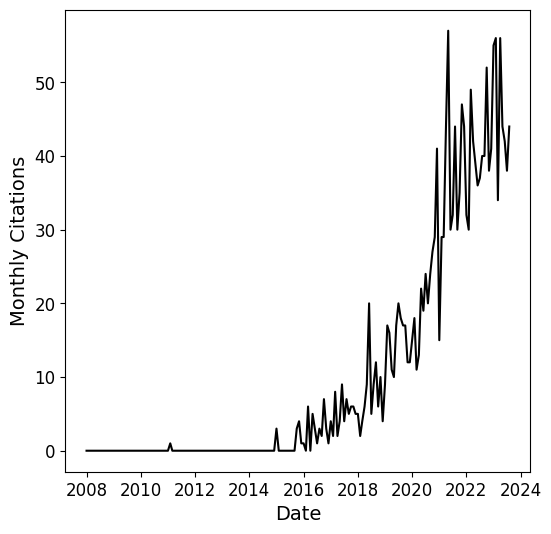

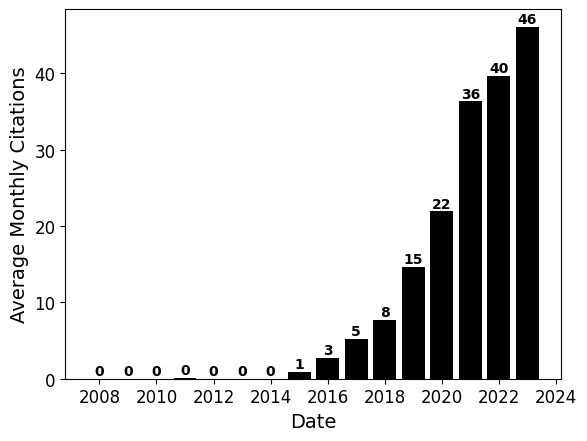

In [172]:
all_monthly_counts = {}
for db in MIMIC_citations.keys():
    all_monthly_counts[db] = dict(Counter([(d.year,d.month) for d in MIMIC_citations[db]]))
    # all_monthly_counts = sorted(Counter([(d.year,d.month) for d in MIMIC_citations[db]]).items(), key=lambda dd:dd[0][0])
    # print(db, all_monthly_counts)

# Find the average number of papers cited per month
all_days = list(range(1,31+1))
all_months = list(range(1,12+1))
all_years = range(2008,2023+1)
# citation_times = []
# for y in all_years:
#     for m in all_months:
#         for d in all_days:
#             try:
#                 dd = datetime.datetime(y,m,d)
#             except ValueError:
#                 continue
#             citation_times.append((y,m,d))
citation_times = [(y,m) for y in all_years for m in all_months]

total_monthly_citations = []
average_monthly_citations = []
for y,m in citation_times:
    temp_monthly_citations = 0
    for db in MIMIC_citations.keys():
        try:
            temp_monthly_citations += all_monthly_counts[db][(y,m)]
        except KeyError:
            temp_monthly_citations += 0
    average_monthly_citations.append((y,temp_monthly_citations))
    total_monthly_citations.append(temp_monthly_citations)

buffer_months = 4
average_monthly_citations = average_monthly_citations[:-buffer_months]
total_monthly_citations = total_monthly_citations[:-buffer_months]

average_monthly_citations = [np.mean([c for y,c in average_monthly_citations if y==yy]) for yy in all_years]
print(np.array(list(zip(all_years, average_monthly_citations))).astype(int))

plt.figure(figsize=(6,6))
x_dates = [datetime.datetime(y,m,1) for y,m in citation_times]
plt.plot(x_dates[:-buffer_months], total_monthly_citations, color='k')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Citations', fontsize=14)
# plt.legend(fontsize=12)
# plt.yscale('log')
ax = plt.gca()
ax.tick_params(which='major', labelsize=12)
plt.show()

plt.figure()
plt.bar(all_years, average_monthly_citations, color='k')
ax = plt.gca()
for yy,y in enumerate(all_years):
    ax.text(y, average_monthly_citations[yy]+0.5, f'{average_monthly_citations[yy]:.0f}', horizontalalignment='center', color='k', fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Monthly Citations', fontsize=14)
# plt.legend(fontsize=12)
# plt.yscale('log')
ax = plt.gca()
ax.tick_params(which='major', labelsize=12)
plt.show()

In [173]:
# Total papers cited
np.sum([len(MIMIC_citations[k]) for k in MIMIC_citations])

2036

In [ ]:
start_date = 1900
article_id = 4115250243685522
start_idx = 0
link_dir = f'https://scholar.google.com/scholar?start={start_idx}&hl=en&as_sdt={start_date}&sciodt=0,5&cites={article_id}&scipsc='

# Get the quality of generated papers

### https://scholar.google.com/scholar?start=0&hl=en&as_sdt=2005&sciodt=0,5&cites=4115250243685522&scipsc=
### https://scholar.google.com/scholar?start=10&hl=en&as_sdt=2005&sciodt=0,5&cites=4115250243685522&scipsc=
### https://scholar.google.com/scholar?start=20&hl=en&as_sdt=2005&sciodt=0,5&cites=4115250243685522&scipsc=
### ...

In [21]:
len(re.compile('Related articles').findall(str(soup)))

10

In [46]:
link_dir

'https://scholar.google.com/scholar?start=10&hl=en&as_ylo=2019&as_yhi=2019&sciodt=0,5&cites=4115250243685522&scipsc='

In [144]:
from bs4 import BeautifulSoup
from urllib import request as urllib_request
# from urllib.request import Request, urlopen
import re
# import random
# import requests

DB_NAME = 'UK-Biobank' # 'MIMIC-III

# User-Agent spoofing
# NOTE: this list may get outdated and need updating ... consider ScrapeOps API key?
user_agent_list = [
    'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.2; Trident/6.0; Touch)',
    'Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1',
    'Mozilla/5.0 (iPhone; CPU iPhone OS 5_1 like Mac OS X) AppleWebKit/534.46 (KHTML, like Gecko) Version/5.1 Mobile/9B179 Safari/7534.48.3',
    'Mozilla/5.0 (iPad; U; CPU iPhone OS 3_2 like Mac OS X; en-us) AppleWebKit/531.21.10 (KHTML, like Gecko) Version/4.0.4 Mobile/7B314 Safari/531.21.10',
    'Mozilla/5.0 (Linux; U; Android 4.0.4; en-gb; GT-I9300 Build/IMM76D) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
    'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_3; en-us; Silk/1.1.0-80) AppleWebKit/533.16 (KHTML, like Gecko) Version/5.0 Safari/533.16 Silk-Accelerated=true',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.18363',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36 Edg/87.0.664.75',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36',
]
# proxies = {
#   'http': 'http://10.10.1.10:3128',
#   'https': 'http://10.10.1.10:1080',
# }

# Skip the -1 years since already complete
# TODO: automate this
# TODO: can only go up to 1000, but most of those >1000 should be ~1 at least for these studies
if DB_NAME == 'UK-Biobank':
    # start at 2015
    article_id = 2590122798384494947
elif DB_NAME == 'MIMIC-I':
    # start at 1996
    start_idxs = {
        1996: 0,
        1997: 0,
        1998: 0,
        1999: 0,
        2000: 0,
        2001: 0,
        2002: 0,
        2003: 0,
        2004: 0,
        2005: 0,
        2006: 0,
        2007: 0,
        2008: 0,
        2009: 0,
        2010: 0,
        2011: 0,
        2012: 0,
        2013: 0,
        2014: 0,
        2015: 0,
        2016: 0,
        2017: 0,
        2018: 0,
        2019: 0,
        2020: 0,
        2021: 0,
        2022: 0,
        2023: 0
    }
    article_id = 5955822449530493366
elif DB_NAME == 'MIMIC-II':
    article_id = 7755589053673476801
elif DB_NAME == 'MIMIC-III':
    # start at 2016
    article_id = 4115250243685522
elif DB_NAME == 'MIMIC-IV':
    article_id = 7925337910889488074
elif DB_NAME == 'MIMIC-CXR':
    article_id = 680754441348545603
query_years = list(start_idxs.keys())
results_dict = {y:[] for y in query_years}

total_queries = 0
# Be nice to the bot police
max_queries = 25
for query_year in query_years:
    print(query_year)
    start_idx = start_idxs[query_year]
    if start_idx == -1:
        continue
    # NOTE: Have to go year by year since google scholar does not render more than 100 pages = 1000 citations at a time
    # TODO: Ideally, this would chose dates between every 1000 but that is hard
    # First page
    link_dir = f'https://scholar.google.com/scholar?start=0&hl=en&as_ylo={query_year}&as_yhi={query_year}&sciodt=0,5&cites={article_id}&scipsc='
    temp_user_agent = user_agent_list[-1]
    # proxy_support = urllib_request.ProxyHandler(proxies)
    # opener = urllib_request.build_opener(proxy_support)
    # opener.addheaders = [('User-Agent', temp_user_agent)]
    # urllib_request.install_opener(opener)
    req = urllib_request.Request(link_dir, headers={'User-Agent': temp_user_agent})
    # req.set_proxy('localhost:1234', 'http')
    html_page = urllib_request.urlopen(req).read()
    soup = BeautifulSoup(html_page, 'html.parser')
    # Example: "About 1,250 results (0.09 sec)"
    total_citations = int(re.compile('About (.*) results \\(').findall(str(soup))[0].replace(',',''))
    all_citations = []
    total_queries += 1
    if total_queries == max_queries:
        print('Query limit reached: change `start_idxs` to the end of this execution')
        raise SystemExit(0)

    # NOTE: google scholar shows 10 at a time for now, get the desired page
    for i,temp_idx in enumerate(np.arange(start_idx,total_citations,10)):
        link_dir = f'https://scholar.google.com/scholar?start={temp_idx}&hl=en&as_ylo={query_year}&as_yhi={query_year}&sciodt=0,5&cites={article_id}&scipsc='
        # temp_user_agent = user_agent_list[i%len(user_agent_list)]
        # proxy_support = urllib_request.ProxyHandler(proxies)
        # opener = urllib_request.build_opener(proxy_support)
        # opener.addheaders = [('User-Agent', temp_user_agent)]
        # urllib_request.install_opener(opener)
        req = urllib_request.Request(link_dir, headers={'User-Agent': temp_user_agent})
        # req.set_proxy('localhost:1234', 'http')
        html_page = urllib_request.urlopen(req).read()
        soup = BeautifulSoup(html_page, 'html.parser')
        temp_citations = [int(c) for c in re.compile('Cited by ([0-9]*)').findall(str(soup))]
        # Fill in the rest with 0s since they don't have the 'Cited by ([0-9]*)' phrase
        expected_len = len(re.compile('Related articles').findall(str(soup)))
        all_citations.extend(np.pad(temp_citations, (0,expected_len-len(temp_citations)), 'constant').tolist())
        print(f'DONE: {start_idx+len(all_citations)}/{total_citations}') #{temp_idx+10}/{total_citations}')
        # Avoid the bot police
        total_queries += 1
        if total_queries == max_queries:
            results_dict[query_year] = all_citations
            print('Query limit reached: change `start_idxs` to the end of this execution')
            raise SystemExit(0)
        time.sleep(10)

    results_dict[query_year] = all_citations

2015
2016
2017
2018
2019
2020
2021
2022
2023
DONE: 920/2030
DONE: 930/2030
DONE: 940/2030
DONE: 950/2030
DONE: 960/2030
DONE: 970/2030
DONE: 977/2030
DONE: 977/2030


KeyboardInterrupt: 

# Run these if the above fails mid-way through

In [ ]:
results_dict[query_year] = all_citations
results_dict

# Save the results to a CSV

In [146]:
file_name = f'citations___{DB_NAME}.csv'
try:
    old_df = pd.read_csv(file_name, index_col=0).dropna()
except FileNotFoundError:
    with open(file_name, 'w') as f:
        f.write(',Year,Citations\n')
    old_df = pd.read_csv(file_name, index_col=0).dropna()
new_df = pd.DataFrame(data=[(k,i) for k in results_dict.keys() for i in results_dict[k]], columns=['Year','Citations'])
merged_df = pd.concat([old_df,new_df], ignore_index=True).astype(int)
pd.DataFrame(data=merged_df).to_csv(file_name)

# Visualize the results

In [160]:
c = Counter(total_df)
h_index = 0
for i in np.arange(0,len(total_df)):
    print(i, c[i])
    if c[i] >= i:
        h_index = i
    else:
        break
print(f'h-index = {h_index}')

0 735
1 529
2 479
3 325
4 241
5 254
6 181
7 171
8 147
9 124
10 113
11 121
12 90
13 86
14 84
15 81
16 58
17 64
18 53
19 36
20 44
21 46
22 49
23 50
24 36
25 36
26 32
27 27
28 18
h-index = 27


In [63]:
# TODO: normalize h-index by number of citations

MIMIC-III 133319 5192 735
UK-Biobank 209363 3251 515


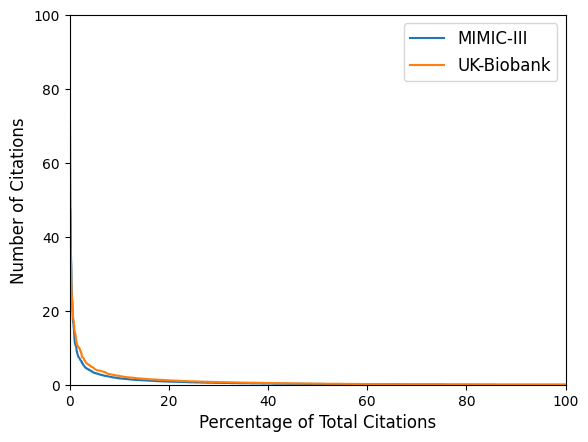

In [104]:
for temp_db_name in ['MIMIC-III', 'UK-Biobank']:
    total_df = list(pd.read_csv(f'citations___{temp_db_name}.csv', index_col=0).to_numpy()[:,1].flatten())

    # PERCENTAGE = False
    # plt.figure(figsize=(6,6))
    # if PERCENTAGE:
    #     plt.hist(total_df, bins=range(min(total_df), max(total_df)+100, 100), weights=100*np.ones(len(total_df))/len(total_df), color='k')
    # else:
    #     plt.hist(total_df, bins=range(min(total_df), max(total_df)+100, 1), color='k')
    # plt.xlabel(f'Citations of Papers Citing {DB_NAME.upper()}', fontsize=12)
    # if PERCENTAGE:
    #     plt.ylabel('Percentage (%)', fontsize=12)
    # else:
    #     plt.ylabel('Counts', fontsize=12)
    # c = Counter(total_df)
    # h_index = 0
    # for i in np.arange(0,len(total_df)):
    #     if c[i] >= i:
    #         h_index = i
    #     else:
    #         break
    # plt.title(f'h-index = {h_index}', fontsize=14)
    # plt.plot([h_index,h_index], [0,h_index], color='r')
    # plt.plot([0,h_index], [h_index,h_index], color='r')
    # if not PERCENTAGE:
    #     plt.xlim([0,1.5*h_index])
    #     # plt.ylim([0,1.5*h_index])
    # plt.show()

    # plt.figure(figsize=(6,6))
    plt.plot(100*np.arange(1,len(total_df)+1)/len(total_df), 100*np.array(sorted(total_df, reverse=True))/max(total_df), label=temp_db_name)#, color='k')
    print(temp_db_name, sum(total_df), len(total_df), len(np.array(total_df)[np.array(total_df)==0]))
plt.xlabel('Percentage of Total Citations', fontsize=12)
plt.ylabel('Number of Citations', fontsize=12)
# plt.title(f'h-index = {h_index}', fontsize=14)
plt.legend(fontsize=12)
plt.xlim([0,100])
plt.ylim([0,100])
# plt.xlim([0,1.1*h_index])
# plt.ylim([0,1.1*h_index])
plt.show()

In [169]:
len(np.array(total_df)[np.array(total_df) > 27])

900

In [27]:
print(len(all_citations))

280
